## 预训练词嵌入

In [1]:
!wget https://deeplearning4jblob.blob.core.windows.net/resources/wordvectors/GoogleNews-vectors-negative300.bin.gz
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2019-07-29 13:01:29--  https://deeplearning4jblob.blob.core.windows.net/resources/wordvectors/GoogleNews-vectors-negative300.bin.gz
Resolving deeplearning4jblob.blob.core.windows.net (deeplearning4jblob.blob.core.windows.net)... 13.66.176.16
Connecting to deeplearning4jblob.blob.core.windows.net (deeplearning4jblob.blob.core.windows.net)|13.66.176.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  19.0MB/s    in 85s     

2019-07-29 13:02:55 (18.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
import gensim
import warnings
warnings.filterwarnings('ignore')

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
model.most_similar(positive=['beijing'])

[('chinese', 0.5550055503845215),
 ('thailand', 0.5427266359329224),
 ('uk', 0.5208765864372253),
 ('hong_kong', 0.5170697569847107),
 ('poland', 0.5152227878570557),
 ('guo', 0.5151727199554443),
 ('london', 0.5148689150810242),
 ('olympics', 0.5135477185249329),
 ('hina', 0.5130335688591003),
 ('cn', 0.511055588722229)]

## word2vec数学特性

In [0]:
def A_is_to_B_as_C_is_to_which(a, b, c, topn=1, model=None):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))  # 封装为list
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        else:
            return [x[0] for x in res]
    return None

In [6]:
A_is_to_B_as_C_is_to_which('son', 'king', 'daughter', 1, model)

'queen'

## 可视化词嵌入

In [0]:
import gensim
import warnings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [0]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
item_vectors = [(item, model[item]) for item in items if item in model]

In [9]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T
tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.019s
[t-SNE] Iteration 50: error = 63.0791779, gradient norm = 0.1129648 (50 iterations in 0.007s)
[t-SNE] Iteration 100: error = 63.6702271, gradient norm = 0.1475802 (50 iterations in 0.006s)
[t-SNE] Iteration 150: error = 70.2805023, gradient norm = 0.7903392 (50 iterations in 0.006s)
[t-SNE] Iteration 200: error = 69.5625076, gradient norm = 0.3285413 (50 iterations in 0.006s)
[t-SNE] Iteration 250: error = 59.5166168, gradient norm = 0.0520608 (50 iterations in 0.006s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.516617
[t-SNE] Iteration 300: error = 0.9665199, gradient norm = 0.0008885 (50 iterations in 0.006s)
[t-SNE] Iteration 350: error = 0.6862286, gradient norm = 0.0005132 (50 i

<Figure size 1152x576 with 0 Axes>

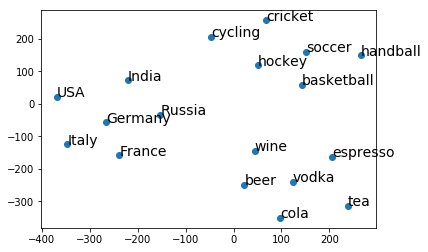

In [10]:
x=tsne[:,0]
y=tsne[:,1]
plt.figure(figsize=(16, 8))
fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)

plt.show()

## 发现实体类

In [0]:
import gensim
import csv
import warnings
import random
warnings.filterwarnings('ignore')

In [11]:
model.most_similar(positive=['Germany'])

[('Austria', 0.7461062669754028),
 ('German', 0.7178750038146973),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.634294867515564)]

In [0]:
countries = list(csv.DictReader(open('data/countries.csv')))

In [18]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['StreamBase_CEP', 'Bruce_Wigo', 'stepper_motor', 'pate_de_verre']

In [19]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [20]:
from sklearn import svm
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [21]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.71655328798185,
 [('Rwanda', 0),
  ('Gaza_Strip', 1),
  ('Reunion', 1),
  ('Vatican', 1),
  ('Mongolia', 1),
  ('Jordan', 1),
  ('Israel', 1),
  ('Argentina', 1),
  ('Aruba', 1),
  ('Cuba', 0)])

In [0]:
all_predictions = clf.predict(model.syn0)

In [0]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

## 类内部语义距离

In [0]:
import gensim
import csv
import warnings
import random
import numpy as np
warnings.filterwarnings('ignore')

In [0]:
countries = list(csv.DictReader(open('data/countries.csv')))

In [0]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])

In [0]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [26]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

## 可视化国家数据

In [0]:
!pip install geopandas

In [0]:
import gensim
import csv
import warnings
import random
import numpy as np
import geopandas as gpd
warnings.filterwarnings('ignore')

In [0]:
countries = list(csv.DictReader(open('data/countries.csv')))

In [0]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])

In [0]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [0]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

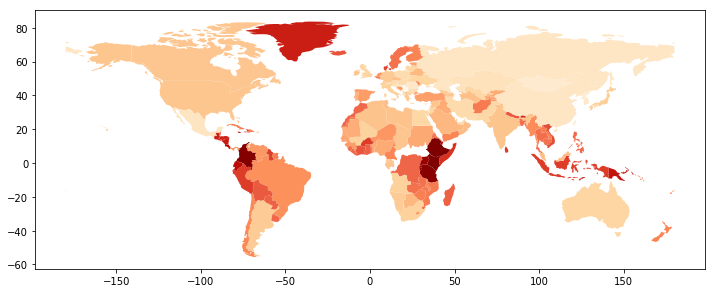

In [35]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
figsize(12, 8)
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')